In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from models import (TorchComplexMLP, ImaginaryDimensionAdder, 
                    cplx2tensor, ComplexTorchMLP, complex_mse, TanhProb)
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR
from RegscorePy.bic import bic

# Fancy optimizers
from lbfgsnew import LBFGSNew
from madgrad import MADGRAD

Running Python 3.9.7
You can use npar for np.array


In [2]:
# torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You're running on", device)

DATA_PATH = '../PDE_FIND_experimental_datasets/harmonic_osc.mat'
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

spatial_dim = x.shape[0]
time_dim = t.shape[0]

potential = np.vstack([0.5*np.power(x,2).reshape((1,spatial_dim)) for _ in range(time_dim)])
Exact = data['usol']

X, T = np.meshgrid(x, t)

# Adjust the diemnsion of Exact and potential (0.5*x**2)
if Exact.T.shape == X.shape: Exact = Exact.T
if potential.T.shape == X.shape: potential = potential.T
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

# Converting in a feature vector for each feature
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
h_star = to_column_vector(Exact)
u_star = to_column_vector(Exact_u)
v_star = to_column_vector(Exact_v)

# Doman bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Converting the grounds to be tensor
X_star = to_tensor(X_star, True)
h_star = to_complex_tensor(h_star, False)

N = 2000; include_N_res = 2
idx = np.random.choice(X_star.shape[0], N, replace=False)
# idx = np.arange(N) # Just have an easy dataset for experimenting

lb = to_tensor(lb, False).to(device)
ub = to_tensor(ub, False).to(device)

X_train = to_tensor(X_star[idx, :], True).to(device)
u_train = to_tensor(u_star[idx, :], False).to(device)
v_train = to_tensor(v_star[idx, :], False).to(device)
h_train = torch.complex(u_train, v_train).to(device)

# Unsup data
if include_N_res>0:
    N_res = int(N*include_N_res)
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = idx_res[:N_res]
    X_res = to_tensor(X_star[idx_res, :], True)
    print(f"Training with {N_res} unsup samples")
    X_train = torch.vstack([X_train, X_res])

# Potential is calculated from x
# Hence, Quadratic features of x are required.
feature_names = ['hf', 'h_x', 'h_xx', 'h_xxx', 'V']

You're running on cpu
Training with 4000 unsup samples


/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_qho/../utils.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr).float().requires_grad_(g)


In [3]:
dt = (t[1]-t[0])[0]
dx = (x[2]-x[1])[0]

fd_h_t = np.zeros((time_dim, spatial_dim), dtype=np.complex64)
fd_h_x = np.zeros((time_dim, spatial_dim), dtype=np.complex64)
fd_h_xx = np.zeros((time_dim, spatial_dim), dtype=np.complex64)
fd_h_xxx = np.zeros((time_dim, spatial_dim), dtype=np.complex64)

for i in range(spatial_dim):
    fd_h_t[:,i] = FiniteDiff(Exact[:,i], dt, 1)
for i in range(time_dim):
    fd_h_x[i,:] = FiniteDiff(Exact[i,:], dx, 1)
    fd_h_xx[i,:] = FiniteDiff(Exact[i,:], dx, 2)
    fd_h_xxx[i,:] = FiniteDiff(Exact[i,:], dx, 3)

fd_h_t = to_column_vector(fd_h_t)
fd_h_x = to_column_vector(fd_h_x)
fd_h_xx = to_column_vector(fd_h_xx)
fd_h_xxx = to_column_vector(fd_h_xxx)
V = to_column_vector(potential)

In [4]:
derivatives = cat_numpy(h_star.detach().numpy(), V, fd_h_x, fd_h_xx, fd_h_xxx)
dictionary = {}
for i in range(len(feature_names)): dictionary[feature_names[i]] = get_feature(derivatives, i)

In [5]:
# This cell is not needed anymore.

# c_poly = ComplexPolynomialFeatures(feature_names, dictionary)
# complex_poly_features = c_poly.fit()
# complex_poly_features

# w = TrainSTRidge(complex_poly_features, fd_h_t, 1e-10, 10)
# print("PDE derived using STRidge")
# print_pde(w, c_poly.poly_feature_names)

In [6]:
PRETRAINED_PATH = "./saved_path_inverse_qho/pretrained_cpinn_2000labeledsamples.pth"

inp_dimension = 2
act = CplxToCplx[torch.tanh]
complex_model = CplxSequential(
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 1, bias=True),
                            )

complex_model = torch.nn.Sequential(
                                    torch.nn.Linear(inp_dimension, 200),
                                    RealToCplx(),
                                    complex_model
                                    )

if PRETRAINED_PATH is not None: complex_model.load_state_dict(cpu_load(PRETRAINED_PATH))

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:597: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


In [7]:
class ComplexNetwork(nn.Module):
    def __init__(self, model, index2features=None, scale=False, lb=None, ub=None):
        super(ComplexNetwork, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        self.scale = scale
        self.lb, self.ub = lb, ub
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, t):
        if not self.scale: self.uf = self.model(torch.cat([x, t], dim=-1))
        else: self.uf = self.model(self.neural_net_scale(torch.cat([x, t], dim=-1)))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = complex_diff(uf, t)
        
        derivatives = []
        ### PDE Loss calculation ###
        # Without calling grad
        # Appending the estimated solutions
        derivatives.append(cplx2tensor(uf))
        
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = complex_diff(out, x)
                elif c=='t': out = complex_diff(out, t)
            derivatives.append(out)
            
        # Appending the potential function
        derivatives.append(0.5*torch.pow(x,2))

        return torch.cat(derivatives, dim=-1), u_t
    
    def neural_net_scale(self, inp):
        return -1 + 2*(inp-self.lb)/(self.ub-self.lb)

In [8]:
class ComplexAttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=5e-2):
        super(ComplexAttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = CplxLinear(layers[0], layers[0], bias=True)
        self.prob_activation = prob_activation
        self.nonlinear_model = ComplexTorchMLP(dimensions=layers, activation_function=CplxToCplx[F.relu](), bn=bn, dropout_rate=0.0)
        self.latest_weighted_features = None
        self.th = (1/layers[0])+(1e-10)
        self.reg_intensity = reg_intensity
        self.w = torch.tensor([1.0, 1.0, 2.0, 3.0, 1.0])/10
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*F.threshold(self.weighted_features(inn), self.th, 0.0))
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn).real).mean(dim=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        l1 = complex_mse(ut_approx, y_input)
        reg_term = F.relu(self.latest_weighted_features-self.th)
        l2 = torch.norm(reg_term, p=0)+torch.dot(self.w, reg_term)
        return l1 + self.reg_intensity*l2

# Only the SemiSupModel has changed to work with the finite difference guidance
class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None, uncert=False):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        self.weights = None
        if uncert: 
            self.weights = torch.tensor([0.0, 0.0])
        
    def forward(self, X_h_train, h_train, include_unsup=True):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_h_train))
        
        h_row = h_train.shape[0]
        fd_guidance = complex_mse(self.network.uf[:h_row, :], h_train)
        
        # I am not sure a good way to normalize/scale a complex tensor
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        
        if include_unsup: unsup_loss = self.selector.loss(X_selector, y_selector)
        else: unsup_loss = None
            
        if include_unsup and self.weights is not None:
            return (torch.exp(-self.weights[0])*fd_guidance)+self.weights[0], (torch.exp(-self.weights[1])*unsup_loss)+self.weights[1]
        else:
            return fd_guidance, unsup_loss

In [9]:
lets_pretrain = False

semisup_model = SemiSupModel(
    network=ComplexNetwork(model=complex_model, index2features=feature_names, scale=True, lb=lb, ub=ub),
    selector=ComplexAttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=TanhProb(), bn=True),
    normalize_derivative_features=True,
    mini=torch.tensor(np.abs(derivatives).min(axis=0), dtype=torch.cfloat), # does not matter, will be replaced
    maxi=torch.tensor(np.abs(derivatives).max(axis=0), dtype=torch.cfloat), # does not matter, will be replaced
    uncert=False,
)

# semisup_model.network.load_state_dict(torch.load("..."))

Considering ['hf', 'h_x', 'h_xx', 'h_xxx', 'V']


#### Pretraining the solver network

In [10]:
if lets_pretrain:
    def pretraining_closure():
        global N, X_h_train, h_train
        if torch.enable_grad(): pretraining_optimizer.zero_grad()
        # Only focusing on first [:N, :] elements
        mse_loss = complex_mse(semisup_model.network(*dimension_slicing(X_train[:N, :])), h_train[:N, :])
        if mse_loss.requires_grad: mse_loss.backward(retain_graph=False)
        return mse_loss
    
    print("Pretraining")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(),
                                     lr=1e-1, max_iter=300,
                                     max_eval=int(300*1.25), history_size=150,
                                     line_search_fn=True, batch_mode=False)

    semisup_model.network.train()    
    for i in range(120):
        pretraining_optimizer.step(pretraining_closure)
            
        if (i%10)==0:
            l = pretraining_closure()
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # See how well the model perform on the test set
            semisup_model.network.eval()
            test_performance = complex_mse(semisup_model.network(*dimension_slicing(X_star)).detach(), h_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)

In [11]:
n_test = 20000
test_idx = np.random.choice(X_star.shape[0], n_test, replace=False)
referenced_derivatives, h_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[test_idx, :]))

In [12]:
derivatives = referenced_derivatives.detach().numpy()

dictionary = {}
for i in range(len(feature_names)): dictionary[feature_names[i]] = get_feature(derivatives, i)

c_poly = ComplexPolynomialFeatures(feature_names, dictionary)
complex_poly_features = c_poly.fit()

w = TrainSTRidge(complex_poly_features, to_numpy(h_t), 1e-10, d_tol=1000, maxit=1000, l0_penalty=5, normalize=1)
print("PDE derived using STRidge")
print_pde(w, c_poly.poly_feature_names)

Computing hf
Computing h_x
Computing h_xx
Computing h_xxx
Computing V
Computing hf^2
Computing hf h_x
Computing hf h_xx
Computing hf h_xxx
Computing hf V
Computing h_x^2
Computing h_x h_xx
Computing h_x h_xxx
Computing h_x V
Computing h_xx^2
Computing h_xx h_xxx
Computing h_xx V
Computing h_xxx^2
Computing h_xxx V
Computing V^2
PDE derived using STRidge
u_t = (-0.000894 +0.494751i)h_xx
    + (0.000650 -0.994282i)hf V
   


#### Joint training

In [13]:
def pcgrad_closure(return_list=False):
    global N, X_train, h_train
    fd_guidance, unsup_loss = semisup_model(X_train, h_train, include_unsup=True)
    losses = [fd_guidance, unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [14]:
# Joint training
# optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
# optimizer.param_groups[0]['lr'] = 1e-7
# optimizer.param_groups[1]['lr'] = 1e-1

# for i in range(50):
#     semisup_model.train()
#     optimizer.step(pcgrad_closure)
    
#     if i%10==0: 
#         loss = pcgrad_closure(return_list=True); print(loss)
#         fi = semisup_model.selector.latest_weighted_features
#         print(fi); print(torch.argsort(fi))

#### Fine-tuning both the solver and selector network

In [15]:
# A cell for saving and loading
# torch.save(semisup_model.state_dict(), "saved_path_inverse_qho/qho_complex_model_2000labeledsamples_jointtrainwith4000unlabeledsamples.pth")
semisup_model = load_weights(semisup_model, "tmp.pth")

Loaded the model's weights properly


In [16]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=350, history_size=350)
# f_opt = LBFGSNew(semisup_model.network.parameters(),
#         lr=1e-1, max_iter=300,
#         max_eval=int(300*1.25), history_size=150,
#         line_search_fn=True, batch_mode=False)

def finetuning_closure():
    global N, X_train, h_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = complex_mse(semisup_model.network(*dimension_slicing(X_train[:N, :])), h_train)
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(200):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

2.0389892597449943e-05
6.586108611372765e-06
5.915461315453285e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06
5.914753273827955e-06


In [17]:
# referenced_derivatives, h_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[test_idx, :]))
# derivatives = referenced_derivatives.detach().numpy()

# dictionary = {}
# for i in range(len(feature_names)): dictionary[feature_names[i]] = get_feature(derivatives, i)

# c_poly = ComplexPolynomialFeatures(feature_names, dictionary)
# complex_poly_features = c_poly.fit()

# w = TrainSTRidge(complex_poly_features, to_numpy(h_t), 1e-10, d_tol=1000, maxit=1000, l0_penalty=5, normalize=1)
# print("PDE derived using STRidge")
# print_pde(w, c_poly.poly_feature_names)

In [18]:
X_selector, y_selector = semisup_model.network.get_selector_data(*dimension_slicing(X_train))
X_selector = (X_selector - semisup_model.mini)/(semisup_model.maxi-semisup_model.mini)

In [19]:
semisup_model.selector.weighted_features(X_selector)
semisup_model.selector.latest_weighted_features

tensor([0.6371, 0.1452, 0.2206, 0.1356, 0.4887], grad_fn=<MeanBackward1>)

In [20]:
f_opt = torch.optim.LBFGS(semisup_model.selector.parameters(), lr=5e-2, max_iter=200, history_size=200)

def finetuning_closure():
    if torch.is_grad_enabled(): f_opt.zero_grad()
    loss = complex_mse(semisup_model.selector(X_selector), y_selector)
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.eval()
semisup_model.selector.train()

max_it = 1
for i in range(max_it):
    f_opt.step(finetuning_closure)
    
    if i%5==0 or i==max_it-1:
        loss = finetuning_closure()
        print(loss.item())
        print(np.argsort(semisup_model.selector.latest_weighted_features.detach().numpy()))

0.003284808248281479
[3 1 2 0 4]


In [25]:
feature_importance = semisup_model.selector.latest_weighted_features.detach().numpy()
print("--- Feature importance ranking ---")
for idx in np.argsort(feature_importance)[::-1]:
    print(feature_names[idx], feature_importance[idx])

--- Feature importance ranking ---
V 0.7488443
hf 0.43340284
h_xx 0.20097099
h_x 0.14522594
h_xxx 0.1355661


In [26]:
save(semisup_model, "semisup_model.pth")

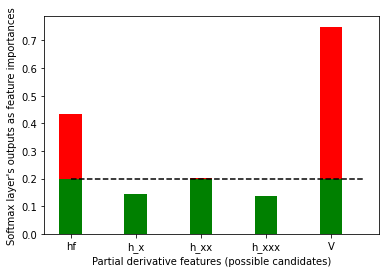

In [27]:
def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.2, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Softmax layer's outputs as feature importances")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names,threshold=0.2, save_path=None)